A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling.

In [40]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string
import time
import math

import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def findFiles(path): 
    return glob.glob(path)

In [3]:
print(findFiles('data/names/*.txt'))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [7]:
# Return all ASCII letters (both lower and upper case)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_letters

57

In [8]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [9]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [15]:
# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])
print(category_lines['English'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


### Turning names into tensors:

Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>. The extra 1 dimension is because PyTorch assumes everything is in batches.

In [24]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>, or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating Network

This RNN module is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

In [27]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [28]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [30]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8134, -2.8416, -2.8171, -2.8544, -2.8806, -2.8574, -2.8914, -2.9934,
         -2.9063, -3.0185, -3.0062, -2.9240, -2.8852, -2.9296, -2.8848, -2.8845,
         -2.8499, -2.8208]], grad_fn=<LogSoftmaxBackward>)


### Preparing for Training

In [31]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 0)


In [34]:

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Acqua
category = Polish / line = Szwedko
category = Polish / line = Slazak
category = Irish / line = Roach
category = Czech / line = Cerv
category = German / line = Jager
category = Korean / line = Gwang 
category = German / line = Voss
category = English / line = Paterson
category = Russian / line = Chuvaldin


### Training the Network

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

Each loop of training will:

-> Create input and target tensors    
-> Create a zeroed initial hidden state    
-> Read each letter in and keep hidden state for next letter    
-> Compare final output to target     
-> Back-propagate    
-> Return the output and loss


In [35]:
criterion = nn.NLLLoss()

In [36]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [38]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.4633 Coiro / Italian ✓
10000 10% (0m 15s) 1.8807 Wang / Chinese ✗ (Korean)
15000 15% (0m 23s) 1.9186 Demko / Polish ✗ (Czech)
20000 20% (0m 30s) 2.2772 Mckay / Russian ✗ (Scottish)
25000 25% (0m 38s) 1.1568 Ping / Vietnamese ✗ (Chinese)
30000 30% (0m 46s) 0.1932 Hachaturov / Russian ✓
35000 35% (0m 54s) 0.3231 Kihara / Japanese ✓
40000 40% (1m 1s) 0.8559 Tolbert / French ✓
45000 45% (1m 9s) 1.2188 Romao / Portuguese ✓
50000 50% (1m 17s) 0.6475 Foerstner / German ✓
55000 55% (1m 25s) 0.7170 Kubo / Japanese ✓
60000 60% (1m 33s) 0.0315 Vamvakidis / Greek ✓
65000 65% (1m 43s) 2.3608 Schwarzenberg / German ✗ (Dutch)
70000 70% (1m 51s) 0.3965 To / Vietnamese ✓
75000 75% (1m 58s) 0.0543 Grzeskiewicz / Polish ✓
80000 80% (2m 6s) 1.9426 Dunnett / French ✗ (English)
85000 85% (2m 14s) 2.9177 Belmonte / Dutch ✗ (Spanish)
90000 90% (2m 21s) 1.1510 Pugliese / Italian ✓
95000 95% (2m 29s) 0.4687 Ziemniak / Polish ✓
100000 100% (2m 36s) 2.0758 Cerney / English ✗ (Czech)


### Plotting the Result

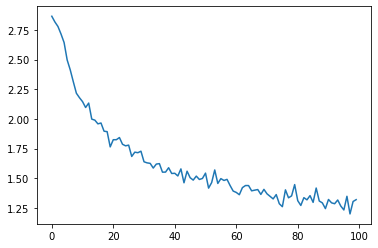

In [41]:
plt.figure()
plt.plot(all_losses)

### Evaluating the Results

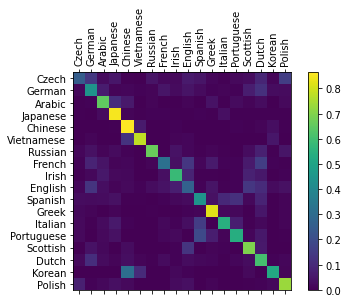

In [42]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Running on User Input

In [43]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.57) Russian
(-1.42) Czech
(-2.49) English

> Jackson
(-0.94) Scottish
(-1.39) Russian
(-1.60) English

> Satoshi
(-0.85) Japanese
(-1.54) Arabic
(-2.13) Polish
